In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import matplotlib.cm as cm
from sklearn.metrics.pairwise import *
from sklearn.cluster import *
from scipy import linalg as LA


class Spectral:
    def __init__(self,filename,clusters,sigma,choice,eigen_gap):
        self.filename = filename
        self.clusters = int(clusters)
        self.sigma = sigma
        self.choice = choice
        self.eigen_gap = eigen_gap

    
    def RbfKernel(self,data1, data2, sigma):
        delta =np.matrix(abs(np.subtract(data1, data2)))
        squaredEuclidean = (np.square(delta).sum(axis=1))
        result = np.exp(-(squaredEuclidean)/(2*self.sigma**2))
        return result
    
    def graphplot(self,cluster_assignment,points):
        row,col = points.shape
        if col <= 2 :
            pca_plot_matrix = points
        else:
            pca_plot_matrix = PCA(n_components=2).fit_transform(points)
        plot_unique_labels = list(set(cluster_assignment))
        unique_naming_list_1=[]

        colours_unique_vector = cm.Set1(np.linspace(0, 1, len(plot_unique_labels)))

        for i in range(len(plot_unique_labels)):
            dis_rows_index = np.where(cluster_assignment==plot_unique_labels[i])
            dis_rows = pca_plot_matrix[dis_rows_index]
            x_plot =[dis_rows[:,0]]
            y_plot = [dis_rows[:,1]]
            unique_naming_list_1.append(plt.scatter(x_plot, y_plot, c=colours_unique_vector[i]))

                #plt.scatter(x_plot,y_plot,c=colours_unique_vector[i])
        plot_unique_labels=[x+1 for x in plot_unique_labels]
        plot_unique_labels=np.array(plot_unique_labels,dtype=int)

        plt.legend(unique_naming_list_1,plot_unique_labels,loc="best",ncol=1,markerfirst=True,shadow=True)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.title("Spectral using PCA to visualize "+self.filename,fontweight="bold")
        plt.show()
        
        
    def calculateJacRand(self,ground_truth,cluster_assignment,data):
        true_pos = 0
        true_neg = 0
        false_pos=0
        false_neg=0
        for i in range(len(data)):
            for j in range(len(data)):
                if ground_truth[i]==ground_truth[j]:
                    if cluster_assignment[i]==cluster_assignment[j]:
                        true_pos=true_pos+1
                    else:
                        false_neg=false_neg+1
                elif ground_truth[i]!=ground_truth[j]:
                    if cluster_assignment[i]==cluster_assignment[j]:
                        false_pos=false_pos+1
                    else:
                        true_neg=true_neg+1
        jaccard_value=(true_pos)/(true_pos+false_pos+false_neg)
        rand_index_value=(true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)

        return jaccard_value,rand_index_value


    def spectralClustering(self):
        with open(self.filename) as textFile:
            lines=[line.split() for line in textFile]
        data=np.asarray(lines)
        gene_id = data[:,0]
        ground_truth = data[:,1]
        points= np.matrix(data[:,2:],dtype=float,copy=False)
        ndata = points.shape[0]
        result = np.matrix(np.full((ndata , ndata) , 0 , dtype=float))

        for i in range(ndata):
            for j in range(ndata):
                result[i ,j] = self.RbfKernel(points[i,:] , points[j , :] , self.sigma)


        D = np.diag(result.sum(axis=1))
        L = D-result

        return L,D,points,ground_truth,data




    def transformToSpectral(self,laplacian):
        k = self.clusters
        e_vals, e_vecs = LA.eig((laplacian))
        ind = e_vals.real.argsort()[:k]
        result = np.ndarray(shape=(laplacian.shape[0],0))
        for i in range(1, ind.shape[0]):
            cor_e_vec = np.transpose(np.matrix(e_vecs[:,(ind[i]).item()]))
            result = np.concatenate((result, cor_e_vec), axis=1)
        return result

    def transformToSpectralEigen(self,laplacian):
        global eigen_gap
        e_vals, e_vecs = LA.eig((laplacian))
        sorted_eigen_values = np.sort(e_vals.real)[::-1]
        eigen_gap = np.argmax(np.diff(e_vals.real))
        k = eigen_gap+1
        ind = e_vals.real.argsort()[:k]
        result = np.ndarray(shape=(laplacian.shape[0],0))
        for i in range(1, ind.shape[0]):
#             cor_e_vec = np.transpose(np.matrix(e_vecs[:,np.asscalar(ind[i])]))
            cor_e_vec = np.transpose(np.matrix(e_vecs[:,ind[i].item()]))
            result = np.concatenate((result, cor_e_vec), axis=1)
        return result




Enter the file name : cho.txt
Enter the number of clusters : 5
Enter the sigma value : 2.5
do you want to enter the centroid points ? 1: Yes 2: No1
Enter the 1th ID : 32
Enter the 2th ID : 22
Enter the 3th ID : 11
Enter the 4th ID : 33
Enter the 5th ID : 43


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

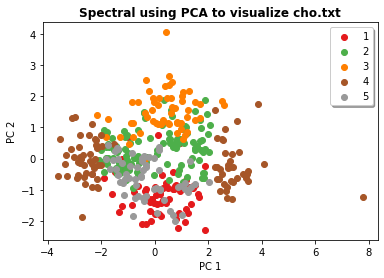

Jaccard Coefficient =  0.19748841922408802
Rand Index =  0.7023410024430186


In [5]:
filename = input("Enter the file name : ")
clusters = input("Enter the number of clusters : ")
sigma = float(input("Enter the sigma value : "))
choice = input("do you want to enter the centroid points ? 1: Yes 2: No")
spec = Spectral(filename,clusters,sigma,choice,0)

L,D,points,ground_truth,data = spec.spectralClustering()

if choice == '2':
    tr = spec.transformToSpectral(L)
    kmeans = KMeans(n_clusters=int(clusters), random_state=0).fit(tr.real)
elif choice == '1':
    tr = spec.transformToSpectral(L)
    centroid_points = []
    for i in range(int(clusters)):
        id = input("Enter the " + str(i+1) + "th ID : ")
        centroid_points.append(int(id)-1)
    attributes = tr[centroid_points, :]
    kmeans = KMeans(n_clusters=int(clusters), random_state=0).fit(tr.real)
else:
    tr = spec.transformToSpectralEigen(L)
    print("number of clusters = {}".format(spec.eigen_gap+1))
    kmeans = KMeans(n_clusters=spec.eigen_gap+1, random_state=0).fit(tr.real)
    

cluster_assignment = kmeans.labels_
cluster_assignment=np.asarray(cluster_assignment,dtype=int)

spec.graphplot(cluster_assignment,points)

jaccard_value,rand_index_value=spec.calculateJacRand(ground_truth,cluster_assignment,data)


print("Jaccard Coefficient = ",jaccard_value)
print("Rand Index = ",rand_index_value)
